In [ ]:
#run this command to install required libraries
#pip install -r requirements.txt

In [1]:
import pickle
import cProfile
import pstats
import os

In [2]:
current_directory = os.getcwd()  # Get the current working directory
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
print("Parent Directory:", parent_directory)

Parent Directory: C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model


In [3]:
# Load serialized data 
with open(parent_directory+'\\data\\dates.pkl', 'rb') as file:
    dates = pickle.load(file)
    
with open(parent_directory+'\\data\\facility_date_time_step_urbano_agent_dic.pkl', 'rb') as file:
    facility_date_time_step_urbano_agent_dic = pickle.load(file)
with open(parent_directory+'\\data\\urbano_agent_date_time_step_facility_dic.pkl', 'rb') as file:
    urbano_agent_date_time_step_facility_dic = pickle.load(file)
    
with open(parent_directory+'\\data\\urbano_agents_travelers_mapping.pkl', 'rb') as file:
    urbano_agents_travelers_mapping = pickle.load(file)
with open(parent_directory+'\\data\\traveler_urbano_agent_mapping.pkl', 'rb') as file:
    traveler_urbano_agent_mapping = pickle.load(file)
    
with open(parent_directory+'\\data\\time_use_baseline_dict.pkl', 'rb') as file:
    time_use_baseline_dict = pickle.load(file)
with open(parent_directory+'\\data\\county_mobility_changes_dict.pkl', 'rb') as file:
    county_mobility_changes_dict = pickle.load(file)
with open(parent_directory+'\\data\\stationary_distributions.pkl', 'rb') as file:
    stationary_distributions = pickle.load(file)
with open(parent_directory+'\\data\\facility_to_index.pkl', 'rb') as file:
    facility_to_index = pickle.load(file)

In [4]:
from facility import Facility
from megaagent import State, MegaAgent

from seirstat import Statistics
from preprocessing import SimulationPeriodBasicInfo
from parameters import Parameters, VariedInfectionDurationResponse
from interventions import GeneralTesting, ContactTracing
from simulation import Simulation

G:\Anaconda\envs\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Debug

In [5]:
repetitions = 1
initial_exposed_count = 10
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5

parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
                                                             rate_from_E_to_I=1/2, 
                                                             rate_from_asymI_to_R=1/8, 
                                                             rate_from_symI_to_R=1/8, 
                                                             asym_fraction=0, 
                                                             asym_hazard_multiplier=asym_hazard_multiplier)


# # enable this block if conduct testing, contact tracing, and quarantine
# parameters.probs_to_be_tested = {"S":0.1,"E":0.4,"Is":0.8,"Ia":0.4,"R":0.1} 
# parameters.test_accuracy_rate = 0.8
# parameters.prob_of_self_report = 0.2
# parameters.quarantine_prob = 0.05
# parameters.conduct_testing = GeneralTesting(parameters.probs_to_be_tested, 
#                                          parameters.test_accuracy_rate,
#                                          parameters.prob_of_self_report)

# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                      facility_date_time_step_urbano_agent_dic,
                                                      urbano_agent_date_time_step_facility_dic,
                                                      urbano_agents_travelers_mapping,
                                                      traveler_urbano_agent_mapping,
                                                      time_use_baseline_dict,
                                                      county_mobility_changes_dict,
                                                      stationary_distributions,
                                                      facility_to_index)

In [6]:
# Create all Facility objects
all_facilities_objects = {}
for f_name in simulation_period_basic_info.AllFacilityNames:
    facility_object = Facility(f_name, simulation_period_basic_info)
    all_facilities_objects[f_name] = facility_object


# Create all MegaAgents
all_mega_agents = {}
for MegaAgentName in simulation_period_basic_info.mega_agent_Urbano_mapping.keys():
    travelers_in_mega_agent = simulation_period_basic_info.MegaAgent_Travelers[MegaAgentName]   
    if travelers_in_mega_agent==0:
        continue
        
    mega_agent = MegaAgent(MegaAgentName,travelers_in_mega_agent,simulation_period_basic_info)
    all_mega_agents[MegaAgentName] = mega_agent

# initialize Statistics
stat = Statistics(all_mega_agents, dates)

In [7]:
%%time
with cProfile.Profile() as pr: 

    for _ in range(repetitions):
#         initial_infectious = np.random.choice(list(simulation_period_basic_info.AllTravelers), 
#                                               replace = False, 
#                                               size = parameters.initial_exposed_count)
        initial_infectious = list(simulation_period_basic_info.AllTravelers)[:parameters.initial_exposed_count]

        for mega_agent_name, mega_agent in all_mega_agents.items():
            if mega_agent.MegaAgentPopulation == 0:
                continue

            if not mega_agent.MegaAgentState.S_travelers.isdisjoint(initial_infectious):
                initial_infectious_travelers_in_mega_agent = list(mega_agent.MegaAgentState.S_travelers.intersection(initial_infectious))
            else:
                continue

            first_date = dates[0]
            mega_agent.dynamic_time_spent_dic = mega_agent.get_dynamic_time_spent(first_date)
#             mega_agent.labelTravelsAsExposed(first_date, 
#                                              1,
#                                              all_facilities_objects, 
#                                              initial_infected=initial_infectious_travelers_in_mega_agent)
#             mega_agent.MegaAgent_daily_update(first_date, parameters) 
            mega_agent.initialize_MegaAgent(first_date, parameters, initial_infectious_travelers_in_mega_agent)
            mega_agent.record_daily_stat(first_date, stat)   
            parameters.conduct_testing.test(mega_agent, 
                                            first_date, 
                                            all_facilities_objects, 
                                            parameters.contact_trace_date_length, 
                                            parameters.quarantine_length,
                                            parameters.quarantine_prob)

            parameters.contact_tracing.trace(mega_agent, 
                                            first_date, 
                                            mega_agent.contact_trace_roster,
                                            all_facilities_objects)  
            mega_agent.if_initialized = True


        for date in dates:
            print(date)

            # On each day, at the first time step, calculate dynamic time spent for each travelers
            for mega_agent_name, mega_agent in all_mega_agents.items():
                if mega_agent.if_initialized == True and date == dates[0]:
                    continue
                mega_agent.dynamic_time_spent_dic = mega_agent.get_dynamic_time_spent(date)

            for time_step in range(1,7):
                for f_name, f in all_facilities_objects.items():
                    f.FacilityHazard = f.computeFacilityHazard(date,
                                                                time_step,
                                                                all_mega_agents, 
                                                                parameters, 
                                                                simulation_period_basic_info)
    #                 #print(f.FacilityHazard)

                for mega_agent_name, mega_agent in all_mega_agents.items():
                    if mega_agent.MegaAgentPopulation == 0:
                        continue

                    if mega_agent.if_initialized == True and date == dates[0] and time_step == 1:
                        continue
                    else:
                        mega_agent.labelTravelsAsExposed(date, 
                                                         time_step,
                                                         all_facilities_objects)

                        if len(mega_agent.MegaAgentState.S_travelers) == 0:
                            continue            

#                         print(str(mega_agent.MegaAgentName) + \
#                               ": S_population: " + str(len(mega_agent.MegaAgentState.S_travelers)) +\
#                               ", Risk: " + str(mega_agent.Risk))


            # daily update 
            for mega_agent_name, mega_agent in all_mega_agents.items():
                if mega_agent.MegaAgentPopulation == 0:
                    continue
                if mega_agent.if_initialized == True and date == dates[0]:
                    continue
                    
                mega_agent.MegaAgent_daily_update(date, parameters) 
                mega_agent.record_daily_stat(date, stat)
                
                parameters.conduct_testing.test(mega_agent, 
                                                date, 
                                                all_facilities_objects, 
                                                parameters.contact_trace_date_length, 
                                                parameters.quarantine_length,
                                                parameters.quarantine_prob)
                
                parameters.contact_tracing.trace(mega_agent, 
                                                 date, 
                                                 mega_agent.contact_trace_roster,
                                                 all_facilities_objects)

2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00
2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00
2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00
2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00
2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00
2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00
2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00
CPU times: total: 1min 28s
Wall time: 1min 28s


In [8]:
st = pstats.Stats(pr)
st.sort_stats(pstats.SortKey.TIME)
st.print_stats()

         81955415 function calls in 88.161 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   272160   27.644    0.000   29.209    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling\facility.py:66(computeFacilityHazard)
    52933   25.646    0.000   25.653    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling\megaagent.py:94(calculate_MegaAgent_risk)
    52933   15.633    0.000   16.363    0.000 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling\megaagent.py:110(calculate_susceptible_travelers_risks)
    56699    6.780    0.000   54.834    0.001 C:\Users\Administrator.DESKTOP-D3SVMI5\Documents\GitHub\PySeirCity-Hybrid-ABM-EBM-Epi-Model\SEIRCityModeling\megaagent.py:183(labelTravelsAsExposed)
 19678561    3.626    0.000    3.626    0.000 {met

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Average final exposure count is 94528.0


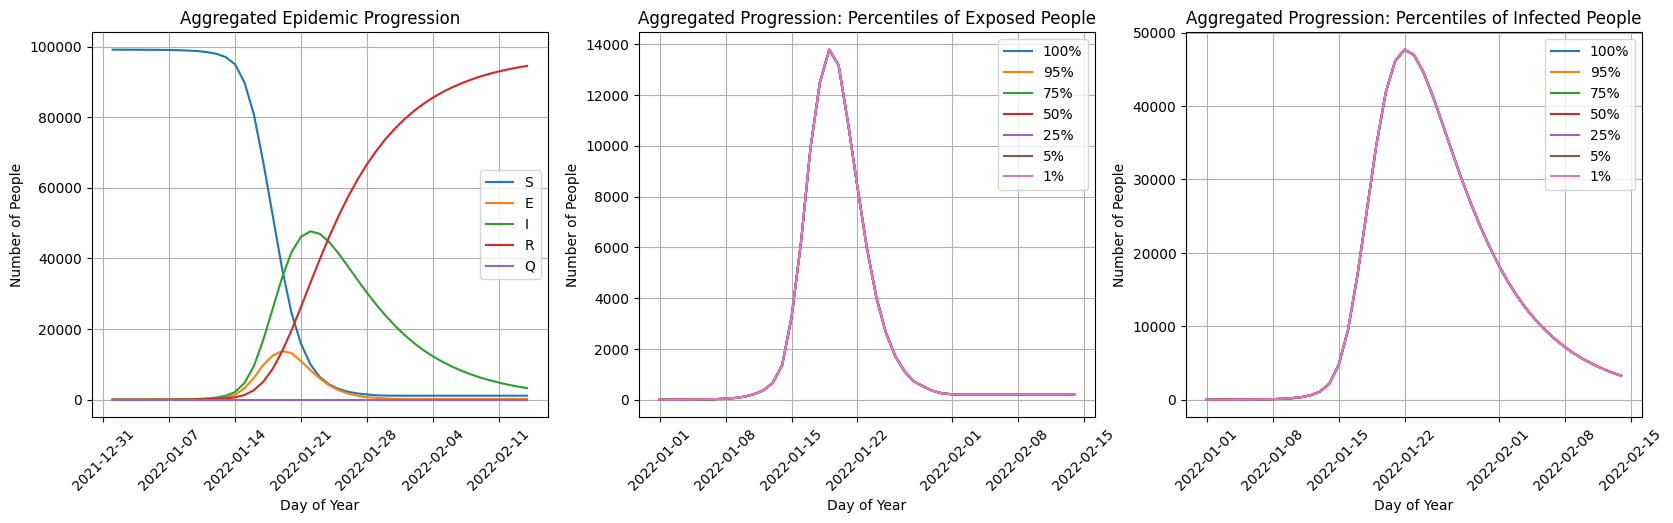

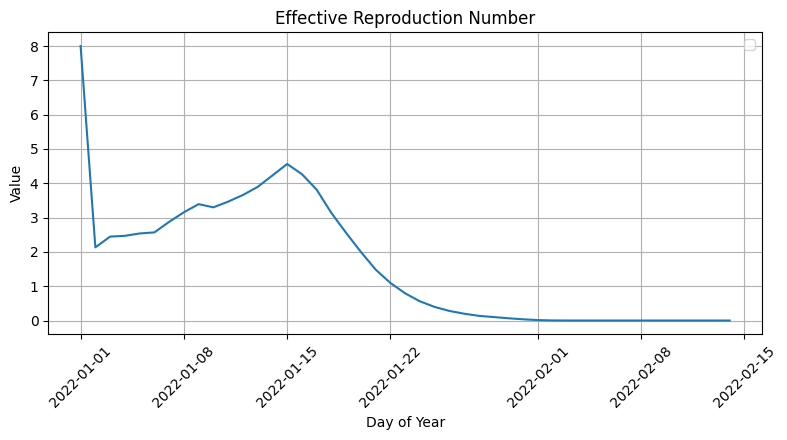

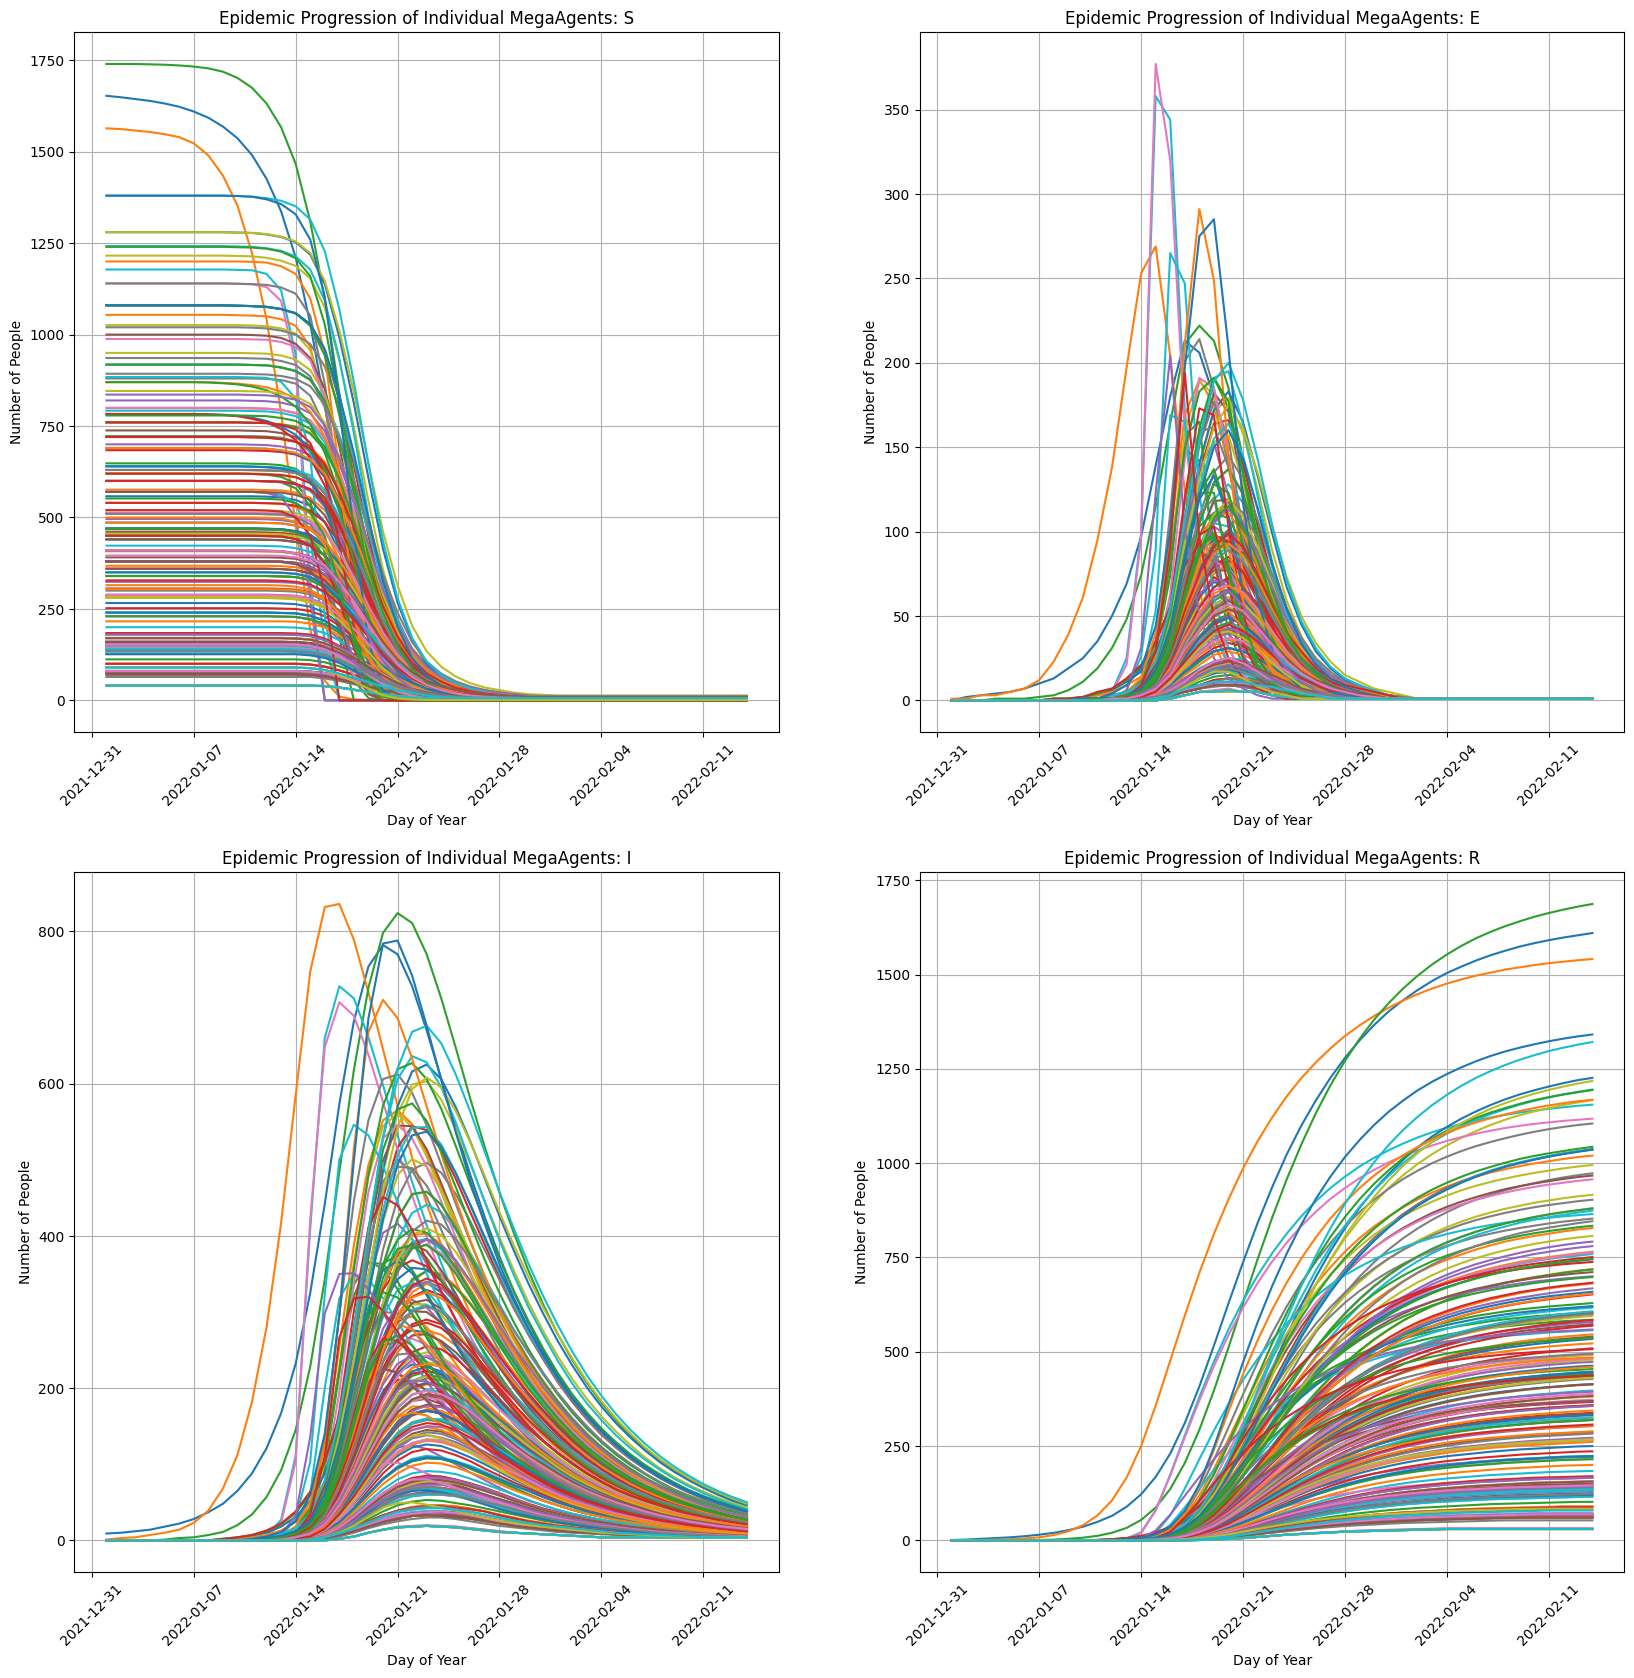

In [9]:
stat.plot_aggregated_progression(parameters)
stat.plot_MegaAgents_progressions()

In [10]:
stat.Reff_agg

{datetime.datetime(2022, 1, 1, 0, 0): [7.999999994181818],
 datetime.datetime(2022, 1, 2, 0, 0): [2.1333333321955554],
 datetime.datetime(2022, 1, 3, 0, 0): [2.4458598716144264],
 datetime.datetime(2022, 1, 4, 0, 0): [2.4689572023724495],
 datetime.datetime(2022, 1, 5, 0, 0): [2.537365545396573],
 datetime.datetime(2022, 1, 6, 0, 0): [2.568414231601644],
 datetime.datetime(2022, 1, 7, 0, 0): [2.8761349300246257],
 datetime.datetime(2022, 1, 8, 0, 0): [3.155453699701895],
 datetime.datetime(2022, 1, 9, 0, 0): [3.3920123075481694],
 datetime.datetime(2022, 1, 10, 0, 0): [3.2993753007393973],
 datetime.datetime(2022, 1, 11, 0, 0): [3.465502774608019],
 datetime.datetime(2022, 1, 12, 0, 0): [3.658739547278121],
 datetime.datetime(2022, 1, 13, 0, 0): [3.8941455306940336],
 datetime.datetime(2022, 1, 14, 0, 0): [4.227164334473063],
 datetime.datetime(2022, 1, 15, 0, 0): [4.562847189155403],
 datetime.datetime(2022, 1, 16, 0, 0): [4.267760646225492],
 datetime.datetime(2022, 1, 17, 0, 0): [3.

In [ ]:
# with open('stat.pkl', 'wb') as file:
#     pickle.dump(stat, file)
# with open('parameters.pkl', 'wb') as file:
#     pickle.dump(parameters, file)

# Basic Simulation

Running 1 repetitions.
Initial exposed: 10
Simulation days: 45 days, 0:00:00


Overall Progress: 100%|████████████████████████████████████████████████████████████████| 45/45 [01:18<00:00,  1.75s/it]


Average final exposure count is 91490.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: total: 1min 28s
Wall time: 1min 28s


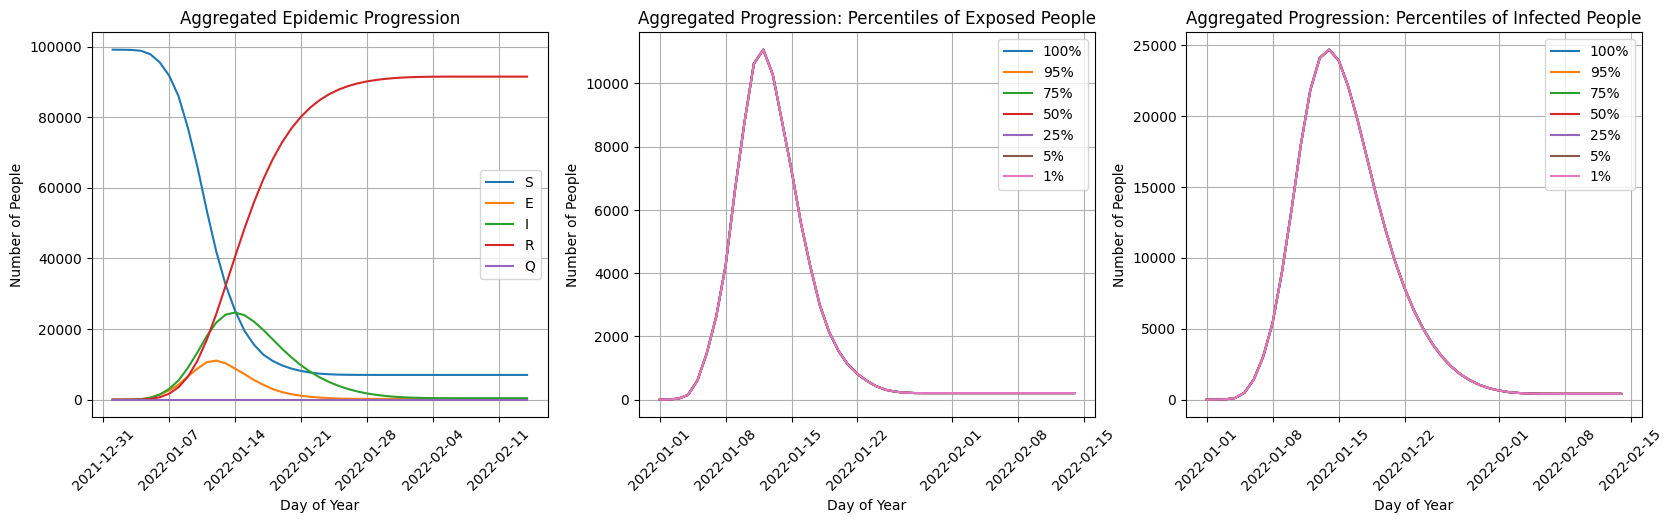

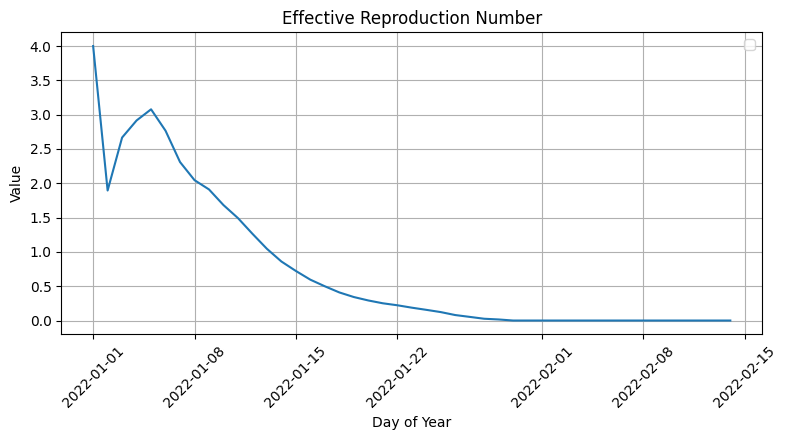

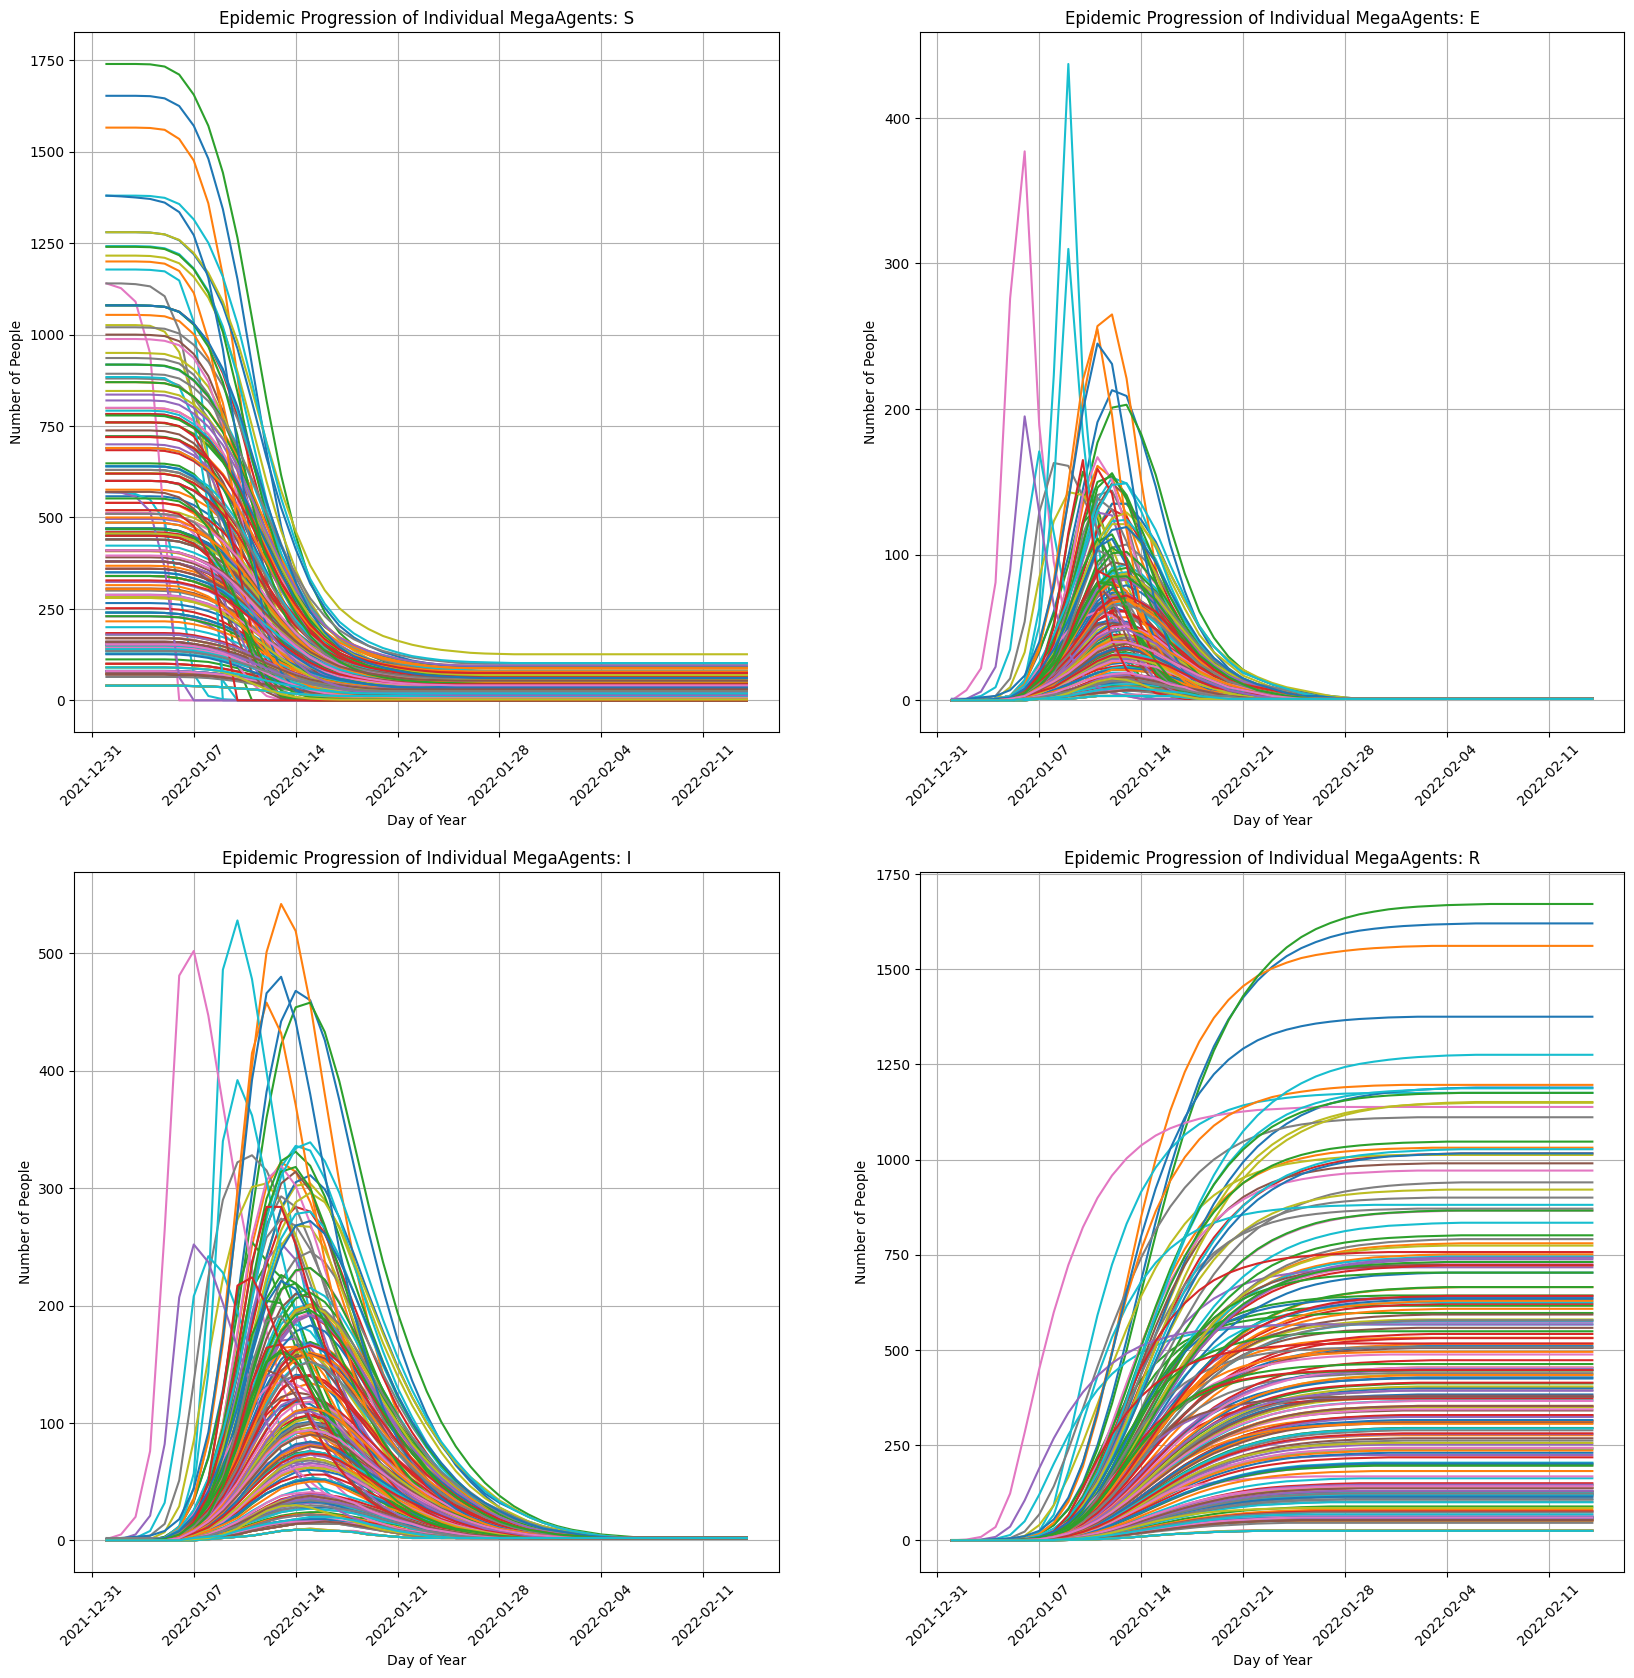

In [5]:
%%time

# specify how many times you wanna run simulation
repetitions = 1
initial_exposed_count = 10
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5
parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
                                                             rate_from_E_to_I=1/2, 
                                                             rate_from_asymI_to_R=1/4, 
                                                             rate_from_symI_to_R=1/4, 
                                                             asym_fraction=0, 
                                                             asym_hazard_multiplier=asym_hazard_multiplier)


# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                      facility_date_time_step_urbano_agent_dic,
                                                      urbano_agent_date_time_step_facility_dic,
                                                      urbano_agents_travelers_mapping,
                                                      traveler_urbano_agent_mapping,
                                                      time_use_baseline_dict,
                                                      county_mobility_changes_dict,
                                                      stationary_distributions,
                                                      facility_to_index)


simulation = Simulation(dates, 
                     simulation_period_basic_info, 
                     parameters, 
                     simulation_period_basic_info.AllFacilityNames)

simulation.run()

# Testing & Contact Tracing & Quarantine

Running 1 repetitions.
Initial exposed: 10
Simulation days: 45 days, 0:00:00


Overall Progress: 100%|████████████████████████████████████████████████████████████████| 45/45 [02:47<00:00,  3.72s/it]


Average final exposure count is 56811.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: total: 3min
Wall time: 3min


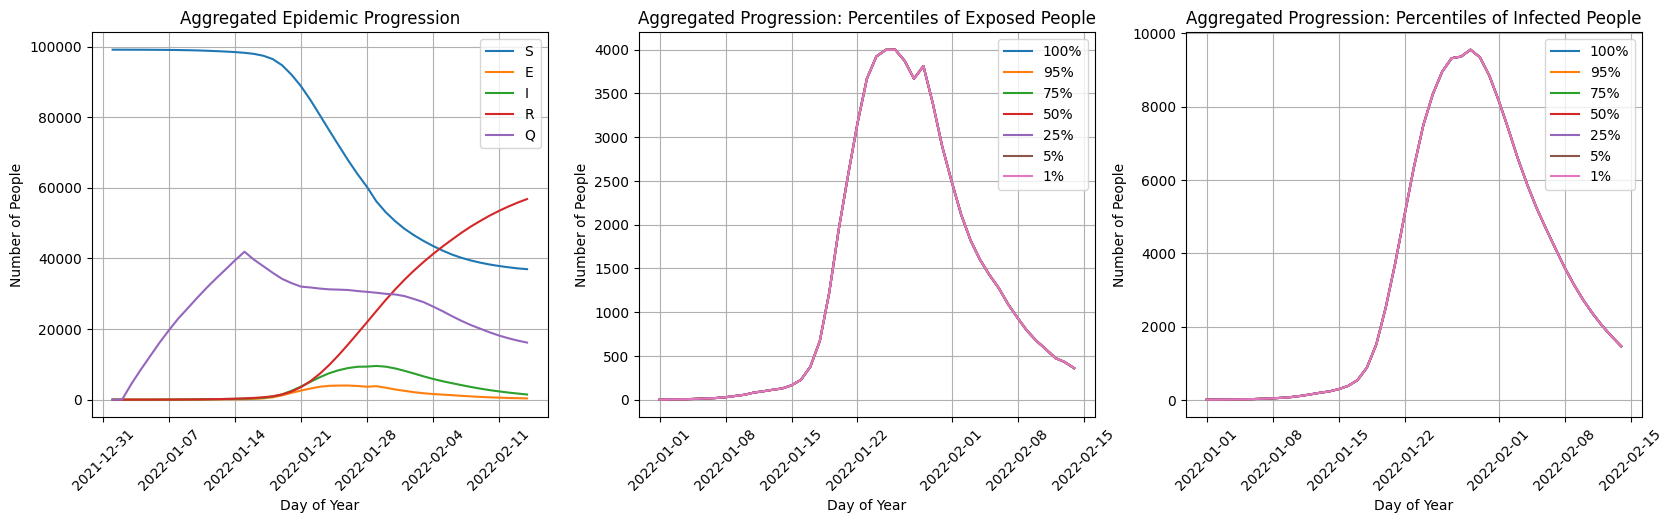

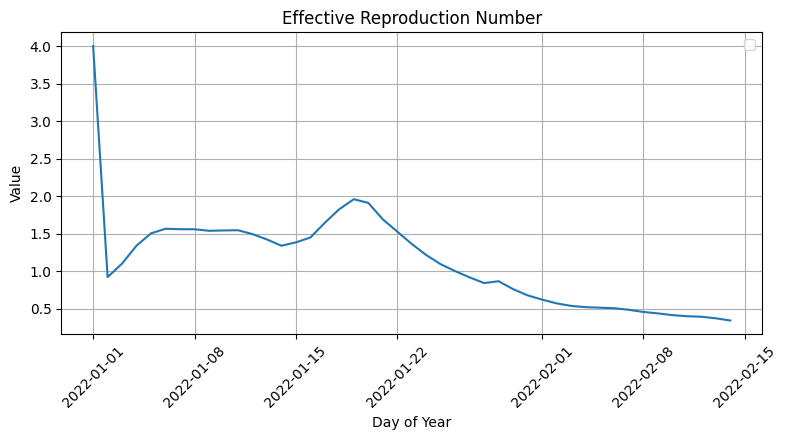

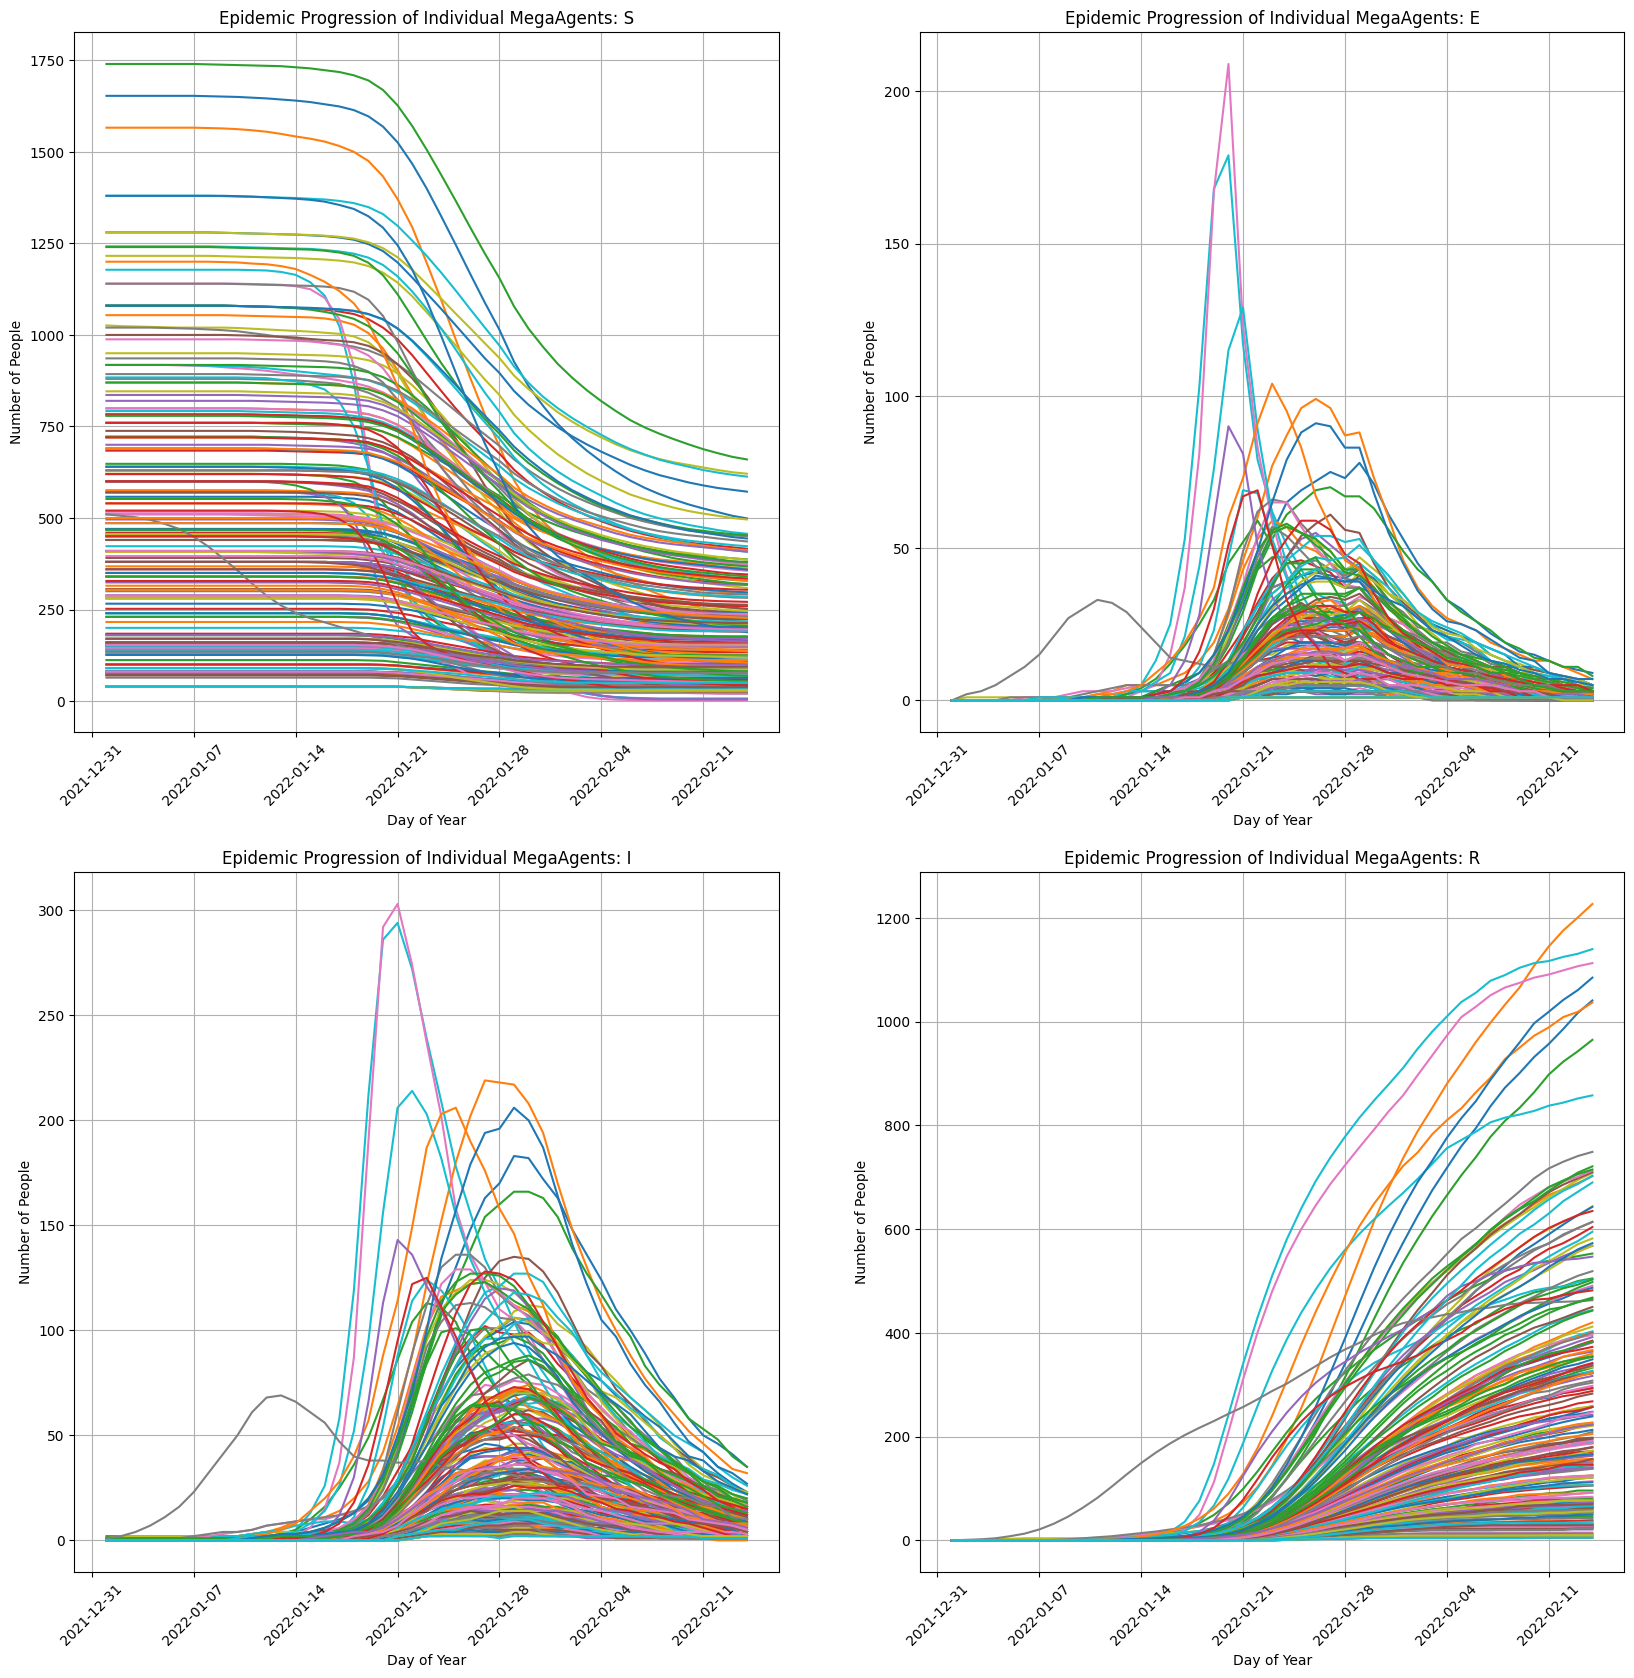

In [6]:
%%time

#with cProfile.Profile() as pr: 

# specify how many times you wanna run simulation
repetitions = 1
initial_exposed_count = 10
# discount percentage of hazard brought by an asymptomatic individual
asym_hazard_multiplier = 0.5
parameters = Parameters(repetitions, initial_exposed_count, asym_hazard_multiplier)
parameters.infection_duration = VariedInfectionDurationResponse(rate_from_S_to_E=2,
                                                             rate_from_E_to_I=1/2, 
                                                             rate_from_asymI_to_R=1/4, 
                                                             rate_from_symI_to_R=1/4, 
                                                             asym_fraction=0, 
                                                             asym_hazard_multiplier=asym_hazard_multiplier)


# Create simulation_period_basic_info object
simulation_period_basic_info = SimulationPeriodBasicInfo(dates,
                                                      facility_date_time_step_urbano_agent_dic,
                                                      urbano_agent_date_time_step_facility_dic,
                                                      urbano_agents_travelers_mapping,
                                                      traveler_urbano_agent_mapping,
                                                      time_use_baseline_dict,
                                                      county_mobility_changes_dict,
                                                      stationary_distributions,
                                                      facility_to_index)


simulation = Simulation(dates, 
                     simulation_period_basic_info, 
                     parameters, 
                     simulation_period_basic_info.AllFacilityNames)


# enable this block if conduct testing
parameters.probs_to_be_tested = {"S":0.1,"E":0.4,"Is":0.8,"Ia":0.4,"R":0.1} 
parameters.test_accuracy_rate = 0.8
parameters.prob_of_self_report = 0.2
parameters.quarantine_prob = 0.05
parameters.conduct_testing = GeneralTesting(parameters.probs_to_be_tested, 
                                         parameters.test_accuracy_rate,
                                         parameters.prob_of_self_report)

simulation.run()

In [ ]:
# st = pstats.Stats(pr)
# st.sort_stats(pstats.SortKey.TIME)
# st.print_stats()